In [1]:
import scanpy as sc
import pandas as pd
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

# Data Exploration: RxRx19b, HUVEC

* [I. Data](#data)
    * [A. What is HUVEC?](#data_sub1)
    * [B. How is RxRx19b structured?](#data_sub2)
* [II. Visualization](#vis)
    * [A. Read in the data](#vis_sub1)
    * [B. Looking into different batch effects](#vis_sub3)
        * [1. Does the data cluster by disease_condition or by plate?](#vis_batch0)
        * [2. Within plate (intra-plate) effects](#vis_batch1)
        * [3. In-between plate (inter-plate) effects](#vis_batch2) 

## I. Data  <a class="anchor" id="data"></a>

<u>*A.  What is HUVEC?*</u> <a class="anchor" id="data_sub1"></a><br>
HUVEC (human umbilical vein endothelial cells) is a cell line that is derived from the endothelium of the human umbilical vein. These cells are often used in vascular research and drug discovery.

*<u>B.  How is RxRx19b structured?*</u> <a class="anchor" id="data_sub2"></a> <br>

RxRx19b modeles the cytokine storm in endothelial cells associated with late-stage COVID-19 using cocktails of circulating proteins. Cocktails were prepared to mimic concentrations of circulating soluble factors in healthy and COVID-19-infected patients. HUVEC cells were treated with each cocktail and resulting morphological changes were observed. 

Structure:
* 1 Experiment: HUVEC-1
* 53 plates
* up to 1380 wells per plate
* 1 site
* 3 channels

**Note:** The wells in the dataset may have different sizes or cell numbers associated with them. A higher count for a particular well indicates that it has more observations (cells) compared to wells with lower counts.
It's important to note that the count alone doesn't provide information about the actual size or number of cells in each well. It simply reflects the number of occurrences of each unique well value in this dataset.

In total we have these many disease_conditions:
* storm-severe:    67364
* healthy:         2756
* blank:            264

In a single plate (except plate 53) we have:
* storm-severe:    1276
* healthy:         52
* blank:           0

Plate 53 has the same condition of "blank" 264 times, 52 times "healthy" and 1012 times "storm-severe".

For more information please see: https://www.rxrx.ai/rxrx19b and https://github.com/theislab/batch_correction_cellpainting/blob/feat/rxrx1_huvec_exploration/data/rxrx19b/rxrx19b_overview.md <br>

## II. Visualization <a class="anchor" id="vis"></a>

### A. Read in the data <a class="anchor" id="vis_sub1"></a>

Read in the embeddings and add metadata to adata.obs + add well row & column to the metadata:

In [2]:
meta_file = "../../data/rxrx19b/metadata.csv"
embedding_file = "../../data/rxrx19b/embeddings.csv"
if not os.path.exists(meta_file):
    raise FileNotFoundError("Please download the metadata from https://www.rxrx.ai/rxrx19b and put the file metadata.csv in the directory data/rxrx19b")
if not os.path.exists(embedding_file):
    raise FileNotFoundError("Please download the embeddings from https://www.rxrx.ai/rxrx19b and put the file embeddings.csv in the directory data/rxrx19b")

In [3]:
adata = sc.read_csv(embedding_file)
meta = pd.read_csv(meta_file, index_col = 0)
# change the order of the rows in the meta data to match the order in the embeddings
meta = meta.reindex(pd.read_csv(embedding_file, index_col = 0).index)
adata.obs = meta
# Split 'well' column into 'well_row' and 'well_column'
adata.obs[['well_row', 'well_column']] = adata.obs['well'].str.extract(r'([A-Z]+)(\d+)')
# Replace NaN values with "blank" in a specific column
adata.obs['disease_condition'] = adata.obs['disease_condition'].fillna("blank")
print(adata)
meta.tail(n=5)

AnnData object with n_obs × n_vars = 70384 × 128
    obs: 'well_id', 'cell_type', 'experiment', 'plate', 'well', 'site', 'disease_condition', 'treatment', 'treatment_conc', 'SMILES', 'well_row', 'well_column'


,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES,well_row,well_column
site_id,,,,,,,,,,,,
HUVEC-1_9_Z42_1,HUVEC-1_9_Z42,HUVEC,HUVEC-1,9,Z42,1,healthy,NaN,0.000,NaN,Z,42
HUVEC-1_9_Z43_1,HUVEC-1_9_Z43,HUVEC,HUVEC-1,9,Z43,1,storm-severe,Netupitant,1.000,CN(C(=O)C(C)(C)C1=CC(=CC(=C1)C(F)(F)F)C(F)(F)F...,Z,43
HUVEC-1_9_Z45_1,HUVEC-1_9_Z45,HUVEC,HUVEC-1,9,Z45,1,storm-severe,Penciclovir,1.000,"NC1=NC(=O)C2=C(N1)N(CCC(CO)CO)C=N2 |c:5,17,t:1|",Z,45
HUVEC-1_9_Z46_1,HUVEC-1_9_Z46,HUVEC,HUVEC-1,9,Z46,1,storm-severe,tilmicosin,0.025,CC[C@@H]1OC(=O)C[C@@H](O)[C@H](C)[C@@H](O[C@@H...,Z,46
HUVEC-1_9_Z47_1,HUVEC-1_9_Z47,HUVEC,HUVEC-1,9,Z47,1,storm-severe,Itopride,0.025,COC1=C(OC)C=C(C=C1)C(=O)NCC1=CC=C(OCCN(C)C)C=C...,Z,47


In [6]:
#Metadata exploration
#meta[(meta["disease_condition"] == 53) & (meta["disease_condition"] == "storm-severe")].shape[0]
meta["treatment"].value_counts()

Allopregnanolone    72
Pyrithione          36
Melphalan           36
ethotoin            36
Fluvoxamine         36
                    ..
YO-01027            24
PRT062607           24
SB239063            24
ARQ 621             24
Filgotinib          24
Name: treatment, Length: 1856, dtype: int64

Save anndata: 

In [12]:
huvec.write_h5ad(
    "rxrx19b_huvec.h5ad",
    compression="gzip"
)

### B. Looking into different batch effects: <a class="anchor" id="vis_sub2"></a>

<font size="3"> **1. Does the data cluster by disease_condition or by plate?** </font> <a class="anchor" id="vis_batch0"></a>

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


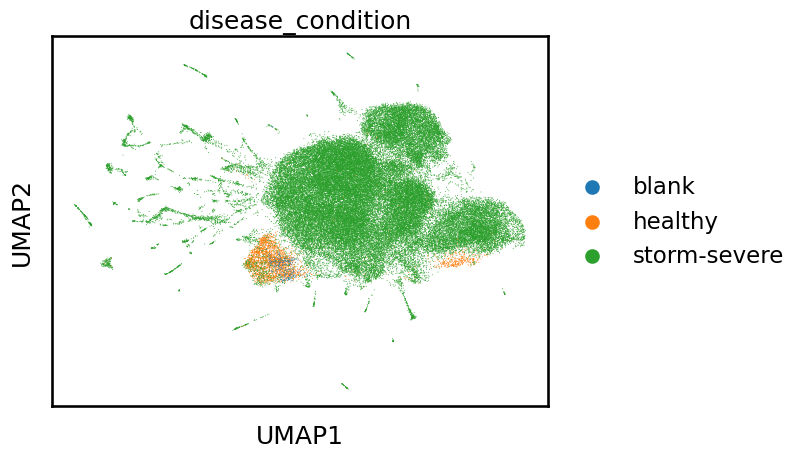

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


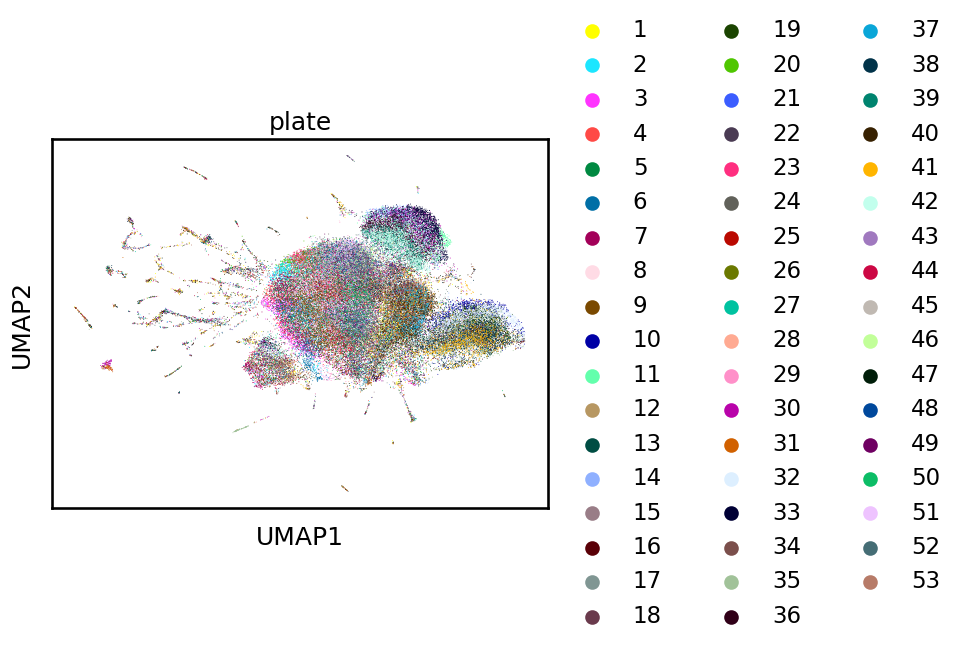

In [21]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep = "X")
sc.tl.umap(adata)
sc.pl.umap(adata, color="disease_condition")
sc.pl.umap(adata, color="plate")

We see that "storm-severe" forms seperate clusters with multiple smaller clusters and does not seem to cluster with  "healthy" or "blank". We can also see that plates cluster to a certain degree as well.

<font size="3"> **2. Within plate (intra-plate) effects** </font> <a class="anchor" id="vis_batch1"></a>

-> We pick plate 53 as this is the only plate which includes the negative control along with healthy and storm-severe conditions.

1. Do the images cluster by well row/column, i.e. well assignment? <br>
2. Do the images cluster by different  disease conditions? <br>
3. Do we see within the group "storm-severe" clusters of treatments? <br>


c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


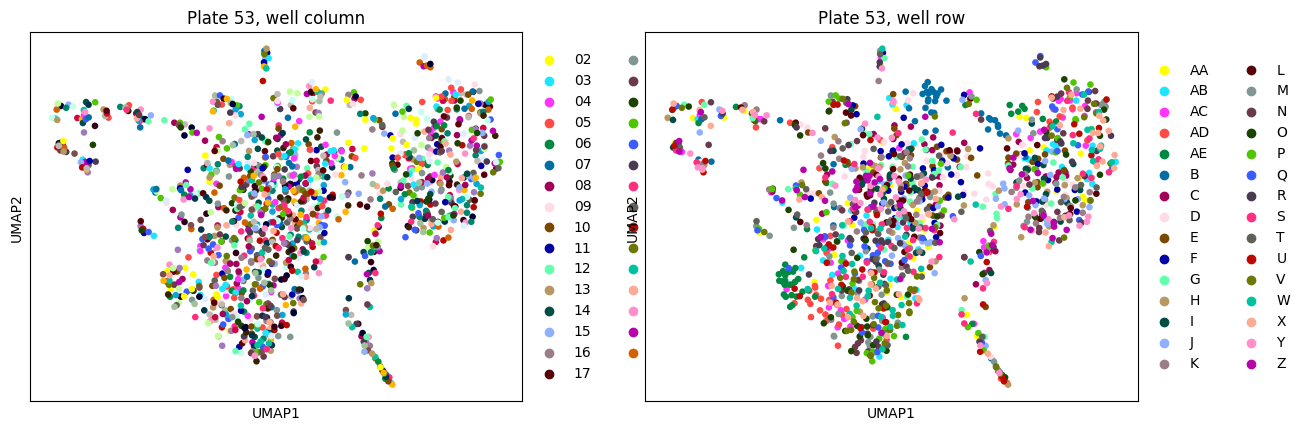

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


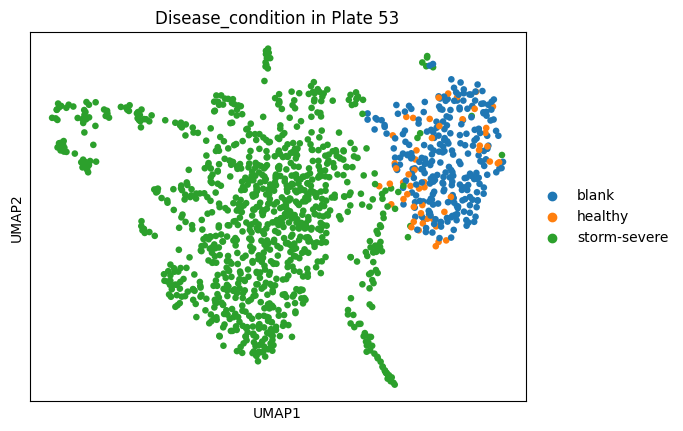

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


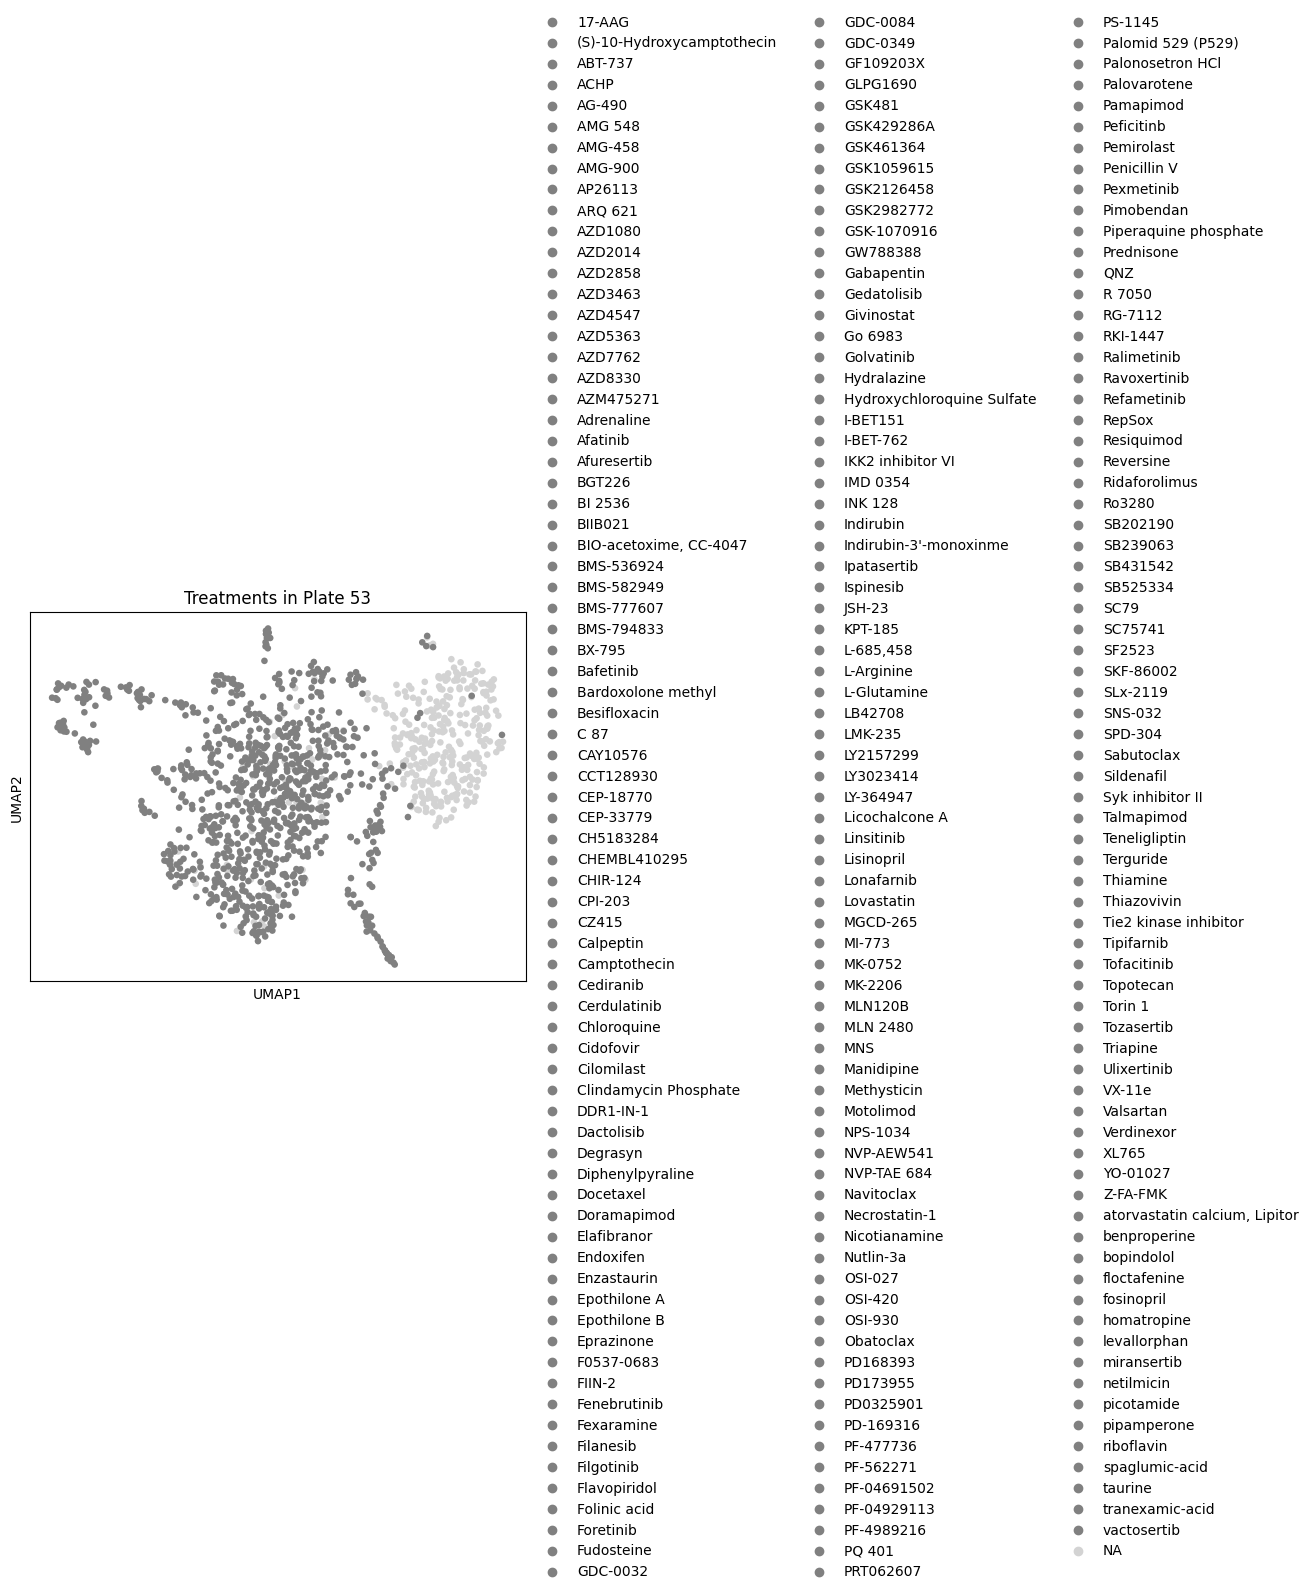

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


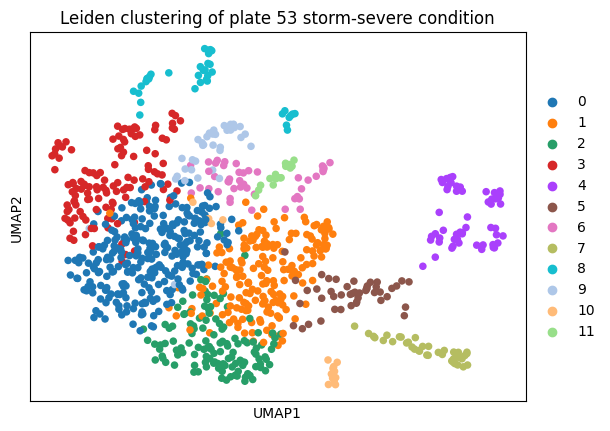

In [68]:
plate53_adata = adata[adata.obs["plate"] == 53]
sc.pp.neighbors(plate53_adata, n_neighbors=15, use_rep = "X")
sc.tl.umap(plate53_adata)
sc.pl.umap(plate53_adata, color=["well_column", "well_row"], title = ["Plate 53, well column", "Plate 53, well row"])

sc.pl.umap(plate53_adata, color=["disease_condition"], title = ["Disease_condition in Plate 53"])
sc.pl.umap(plate53_adata, color=["treatment"], title = ["Treatments in Plate 53"])

plate53_treatment = plate53_adata[plate53_adata.obs["disease_condition"] == "storm-severe"]
sc.pp.neighbors(plate53_treatment, n_neighbors=15, use_rep = "X")
sc.tl.umap(plate53_treatment)
sc.tl.leiden(plate53_treatment, resolution = 0.7)
sc.pl.umap(plate53_treatment, color=['leiden'], title = ["Leiden clustering of plate 53 storm-severe condition"])

Above we can see, that plate 53 does not cluster by well assignment. However, "storm-severe" clearly forms a seperate cluster compared to "healthy" and the negative control with no cytokines. In fact, the "healthy" and "blank" conditions seem to interminge. There are too many treatments for us to be able to tell if certain treatments cluster or not but we can make out a certain level of diversity within the "storm-severe" (and thus treated) cluster. Also, we see that some treatments (possibly outliers) are located within the "healthy" or "blank" cluster.

<font size="3"> **3. In-between plate (inter-plate) effects** </font> <a class="anchor" id="vis_batch2"></a>

Do the images cluster by plate assignment? 

1. Subset one treatment for the "storm-severe" group and color by plate. 

-> We chose Allopregnanolone since it has been used as treatment most frequently across all plates. 
Allopregnanolone is a neurosteroid that has been investigated for its potential therapeutic effects in COVID-19. It is a naturally occurring hormone and acts as a positive allosteric modulator of gamma-aminobutyric acid (GABA) receptors in the brain.

2. Does the "healthy" disease-condition cluster across plates?

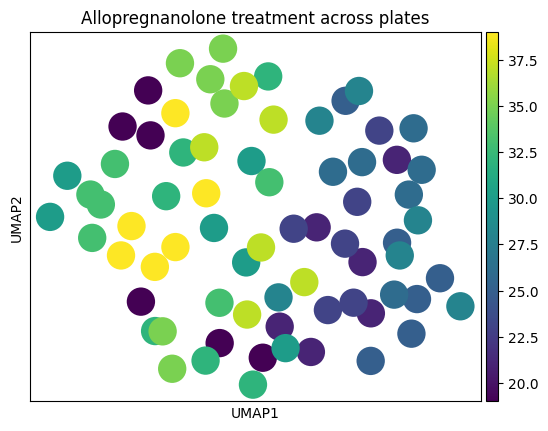

In [78]:
treatment = adata[adata.obs["disease_condition"] == "storm-severe"]
allopregnanolone_treatment = treatment[treatment.obs["treatment"] == "Allopregnanolone"]
sc.pp.neighbors(allopregnanolone_treatment, n_neighbors=15, use_rep = "X")
sc.tl.umap(allopregnanolone_treatment)
sc.pl.umap(allopregnanolone_treatment, color=["plate"], title = "Allopregnanolone treatment across plates")

We see that not all plates contain Allopregnanolone treatment and we do see a little bit of inter-plate clustering for this treatment.

/home/mahim/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mahim/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mahim/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nop

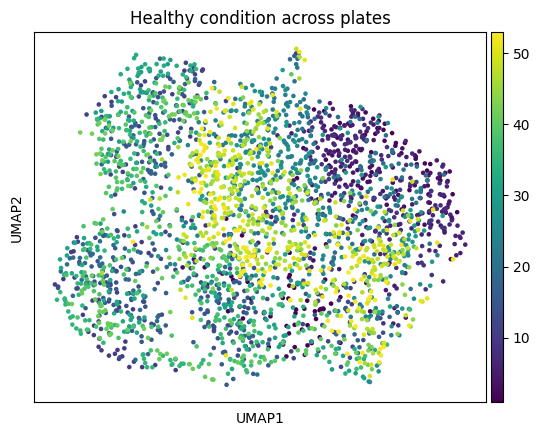

In [4]:
healthy = adata[adata.obs["disease_condition"] == "healthy"]
sc.pp.neighbors(healthy, n_neighbors=15, use_rep = "X")
sc.tl.umap(healthy)
sc.pl.umap(healthy, color=["plate"], title = "Healthy condition across plates")

We also see some inter-plate effect for the "healthy" disease-condition across plates.